# Dirichlet Problem

In this notebook, we solve a problem with Dirichlet boundary conditions using the finite element method.

In [1]:
# perform the various imports that will be useful to me 
from dolfinx import mesh, fem, plot, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
import numpy 
from mpi4py import MPI
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction,
                 div, dx, ds, grad, inner)

## Mesh Generation

We generate the mesh for the domain.

In [2]:
N=8
domain=mesh.create_unit_square(MPI.COMM_WORLD,N,N)
# I have therefore created a mesh of NxN elements (and (N+1)x(N+1) nodes)

# now I create the vector space 
V=fem.functionspace(domain,('Lagrange',1))  # I decide to use polynomials of degree 1 on the single element

## Function Space

We define the function space for the solution.

In [3]:
uD=fem.Function(V) # initialize the function
x=SpatialCoordinate(domain)
u_ex= 1 + x[0]**2 + 2*x[1]**2.   
uD.interpolate(fem.Expression(u_ex,V.element.interpolation_points()))
# interpolates the exact solution on the dofs of the mesh 

f=-div(grad(u_ex))

## Boundary Conditions

We define the boundary conditions for the problem.

In [4]:
u=TrialFunction(V)
v=TestFunction(V)

# define the variables used in the new formulation of this problem
n=FacetNormal(domain)
h=2*Circumradius(domain)
alpha=fem.Constant(domain,default_scalar_type(10))

# now I define a(u,v) and L(v)
a=inner(grad(u),grad(v))*dx - inner(n, grad(u))*v*ds - inner(n,grad(v))*u*ds + alpha/h * inner(u,v)*ds
L = inner(f, v) * dx - inner(n, grad(v)) * uD * ds + alpha / h * inner(uD, v) * ds


In [5]:
# now I go to solve the linear problem 
problem=LinearProblem(a,L) 
# I do not need to specify the BCs because they are already included in the definitions of a and L 
uh=problem.solve()


## Visualization of the Solution

We visualize the solution of the Dirichlet problem.

## Error Calculation

We calculate the error of the numerical solution.

In [6]:
error_form = fem.form(inner(uh-uD, uh-uD) * dx) 
error_local = fem.assemble_scalar(error_form)  # used to compute the scalar value

errorL2 = numpy.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))# to take the square root of the scalar value
# and thus actually compute the L2-error
if domain.comm.rank == 0:
    print(fr"L2 error: {errorL2:.2e}")

L2 error: 1.59e-03


## Convergence Analysis

We analyze the convergence of the method.

In [7]:
error_max=numpy.max(numpy.abs(uD.x.array-uh.x.array))
# I want to print the error with only 1 processor!!!
if domain.comm.rank==0:
    print(f'Error L2: {errorL2:.2e}')
    print(f'Error max: {error_max:.2e}')

Error L2: 1.59e-03
Error max: 5.41e-03


## Analytical Solution

We compare the numerical solution with the analytical solution.

## Conclusions

We summarize the results obtained from the Dirichlet problem.

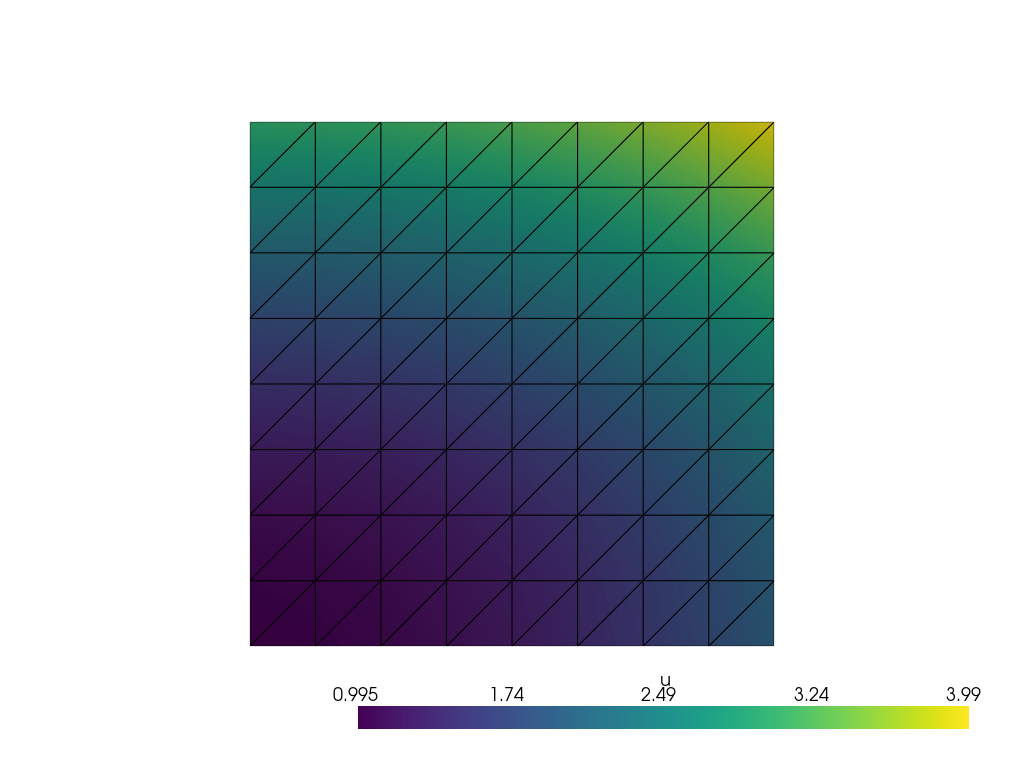

In [8]:
import pyvista

grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
grid.point_data["u"] = uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True, show_scalar_bar=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("nitsche.png")